In [1]:
import pandas as pd
import numpy as np
import regex
from sklearn.linear_model import LogisticRegressionCV
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
dolly_cqa_df = pd.read_parquet('./data/dolly_cqa_prepared.parquet')
dolly_cqa_df

,instruction,context,response,category,text,embeddings_mini_lm,embeddings_bge_large,fk_score,fk_score_categ
0,When did Virgin Australia start operating?,"Virgin Australia, the trading name of Virgin A...",Virgin Australia commenced services on 31 Augu...,closed_qa,"### CONTEXT ###\nVirgin Australia, the trading...","[0.07990753650665283, -0.04975801706314087, 0....","[0.5005730390548706, -0.46779343485832214, -1....",9.131896,easy
1,When was Tomoaki Komorida born?,Komorida was born in Kumamoto Prefecture on Ju...,"Tomoaki Komorida was born on July 10,1981.",closed_qa,### CONTEXT ###\nKomorida was born in Kumamoto...,"[-0.011252421885728836, -0.04460098594427109, ...","[0.64762282371521, 0.43752172589302063, -0.047...",7.643152,easy
2,"Given a reference text about Lollapalooza, whe...",Lollapalooza /ˌlɒləpəˈluːzə/ (Lolla) is an ann...,Lollapalooze is an annual musical festival hel...,closed_qa,### CONTEXT ###\nLollapalooza /ˌlɒləpəˈluːzə/ ...,"[0.06580415368080139, -0.0366082526743412, 0.0...","[0.5144393444061279, 0.18275967240333557, -0.4...",11.617224,medium
3,Who was Kyle Van Zyl playing against when he s...,Van Zyl joined the Eastern Province Kings Acad...,Kyle Van Zyl was playing against Boland U21 wh...,closed_qa,### CONTEXT ###\nVan Zyl joined the Eastern Pr...,"[0.019957538694143295, 0.04702803120017052, -0...","[1.1888214349746704, 0.058644916862249374, -0....",11.474969,medium
4,Who was the first to record the Needles and Pi...,"""Needles and Pins"" is a rock song credited to ...",The first artist to record Needles and Pins so...,closed_qa,"### CONTEXT ###\n""Needles and Pins"" is a rock ...","[-0.08916875720024109, 0.0042908587493002415, ...","[-0.08973768353462219, -0.17643515765666962, 0...",9.573611,easy
...,...,...,...,...,...,...,...,...,...
1456,How many world championships has Max Verstappe...,"After winning the 2021 Abu Dhabi Grand Prix, V...",Max Verstappen has won 2 Formula One World Cha...,closed_qa,### CONTEXT ###\nAfter winning the 2021 Abu Dh...,"[0.044786978513002396, 0.0190593209117651, -0....","[0.5898312330245972, 0.14761556684970856, -0.4...",7.991569,easy
1457,What is the history of coffee?,The history of coffee dates back to centuries ...,Much of the early history of coffee was tied t...,closed_qa,### CONTEXT ###\nThe history of coffee dates b...,"[0.019176138564944267, 0.02772548422217369, -0...","[0.10451232641935349, 0.22819367051124573, -0....",11.447779,medium
1458,What are common florals found in Zigalga Natio...,Zigalga National Park (Russian: Национальный п...,Zigalga National Park has the majority of its ...,closed_qa,### CONTEXT ###\nZigalga National Park (Russia...,"[-0.026473581790924072, 0.09908297657966614, -...","[0.1897222250699997, 0.41683098673820496, 0.02...",12.950833,medium
1459,What is linux Bootloader,"A bootloader, also spelled as boot loader or c...",A bootloader is a program written in machine c...,closed_qa,"### CONTEXT ###\nA bootloader, also spelled as...","[-0.05690043047070503, 0.05346180498600006, -0...","[0.32251039147377014, -0.2482924461364746, 0.0...",19.799659,hard


In [3]:
pattern = r'\baseball(?!: bat)|basketball|badminton|tennis(?!: shoe)|soccer|futbol|football (?!: stadium)'
flags = [bool(regex.search(pattern, sent, regex.IGNORECASE)) for sent in dolly_cqa_df['text']]

dolly_cqa_df['pattern_flag'] = flags

In [4]:
def train_lr_classifier(df, embeddings_col, y_col):
    # Convert the list of lists in X_colname to a numpy array
    X = np.array(df[embeddings_col].tolist())
    
    y = df[y_col]
    
    # Initialize LR classifier
    clf = LogisticRegressionCV(cv=5, scoring='f1_macro', max_iter=10000, n_jobs=-1)

    # Fit the classifier
    clf.fit(X, y)

    return clf

In [5]:
clf = train_lr_classifier(df=dolly_cqa_df, embeddings_col='embeddings_mini_lm', y_col='pattern_flag')

In [6]:
def get_predictions(df, clf, embeddings_col, y_col):
    # Convert the list of lists in X_colname to a numpy array
    X = np.array(df[embeddings_col].tolist())

    # Normalize X
    X = X / np.linalg.norm(X, axis=1, keepdims=True)
    
    y = df[y_col]

    # Predictions
    y_pred = clf.predict(X)

    # Printing the classification report
    print(classification_report(y, y_pred))

    # Plotting the confusion matrix
    cm = confusion_matrix(y, y_pred)
    plt.figure(figsize=(7,5))
    sns.heatmap(cm, annot=True, fmt='g', cmap='Blues')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

              precision    recall  f1-score   support

       False       1.00      1.00      1.00      1363
        True       0.97      0.94      0.95        98

    accuracy                           0.99      1461
   macro avg       0.98      0.97      0.98      1461
weighted avg       0.99      0.99      0.99      1461



c:\Users\vilce\AppData\Local\miniconda3\envs\llm_env\Lib\site-packages\IPython\core\pylabtools.py:152: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "orientation" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\vilce\AppData\Local\miniconda3\envs\llm_env\Lib\site-packages\IPython\core\pylabtools.py:152: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "facecolor" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\vilce\AppData\Local\miniconda3\envs\llm_env\Lib\site-packages\IPython\core\pylabtools.py:152: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "edgecolor" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\vilce\AppData\Local\miniconda3\envs

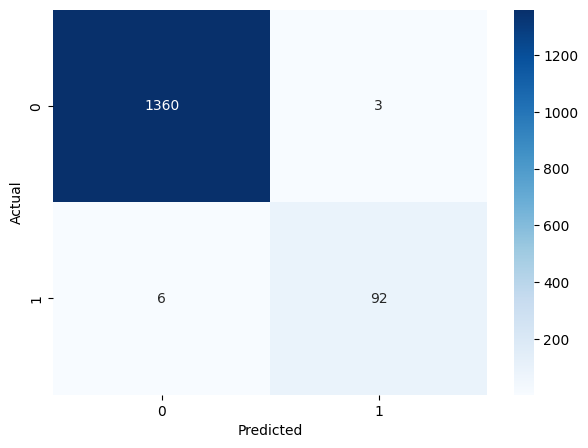

In [7]:
get_predictions(df=dolly_cqa_df, clf=clf, embeddings_col='embeddings_mini_lm', y_col='pattern_flag')

In [8]:
dolly_cqa_df['score'] = clf.predict_proba(X=np.array(dolly_cqa_df['embeddings_mini_lm'].tolist()))[:,1]
dolly_cqa_df['w_embeddings'] = dolly_cqa_df['embeddings_mini_lm'].apply(lambda x: x * clf.coef_[0])
dolly_cqa_df['iw_embeddings'] = dolly_cqa_df['embeddings_mini_lm'].apply(lambda x: x / clf.coef_[0])

n_clusters = 10
seed=0
uw_kmeans = KMeans(n_clusters=n_clusters, random_state=seed, n_init="auto").fit( [v for v in dolly_cqa_df['embeddings_mini_lm']])
w_kmeans = KMeans(n_clusters=n_clusters, random_state=seed, n_init="auto").fit( [v for v in dolly_cqa_df['w_embeddings']])
iw_kmeans = KMeans(n_clusters=n_clusters, random_state=seed, n_init="auto").fit( [v for v in dolly_cqa_df['iw_embeddings']])

dolly_cqa_df['uw_kmeans'] = uw_kmeans.labels_
dolly_cqa_df['w_kmeans'] = w_kmeans.labels_
dolly_cqa_df['iw_kmeans'] = iw_kmeans.labels_

cluster_df = dolly_cqa_df[['uw_kmeans', 'w_kmeans', 'iw_kmeans', 'score']]
cluster_df = pd.melt(cluster_df, id_vars=['score'], var_name='weighting', value_name='cluster_id')
cluster_df = cluster_df.groupby(["weighting", "cluster_id"]).agg({'score': ['mean', 'var']}).reset_index()
cluster_df.columns = ['weighting', 'cluster_id', 'mean_score', 'var_score']

c:\Users\vilce\AppData\Local\miniconda3\envs\llm_env\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=6.
  warnings.warn(
c:\Users\vilce\AppData\Local\miniconda3\envs\llm_env\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=6.
  warnings.warn(
c:\Users\vilce\AppData\Local\miniconda3\envs\llm_env\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=6.
  warnings.warn(


c:\Users\vilce\AppData\Local\miniconda3\envs\llm_env\Lib\site-packages\IPython\core\pylabtools.py:152: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "orientation" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\vilce\AppData\Local\miniconda3\envs\llm_env\Lib\site-packages\IPython\core\pylabtools.py:152: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "facecolor" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\vilce\AppData\Local\miniconda3\envs\llm_env\Lib\site-packages\IPython\core\pylabtools.py:152: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "edgecolor" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\vilce\AppData\Local\miniconda3\envs

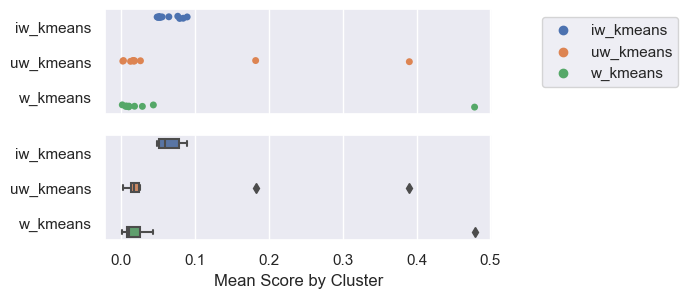

In [9]:
sns.set(rc={"figure.figsize":(5, 3)})
fig, axes = plt.subplots(2, 1, sharey=True)

sns.stripplot(x='mean_score', y='weighting', data=cluster_df, jitter=True, hue='weighting', dodge=True, ax=axes[0])
axes[0].legend(loc='upper right', bbox_to_anchor=(1.5, 1))
axes[0].set(ylabel=None)
axes[0].set(xticklabels=[])
axes[0].set(xlabel=None)

sns.boxplot(x='mean_score', y ='weighting', data=cluster_df, hue='weighting', dodge=True, ax=axes[1])
axes[1].set(ylabel=None)
axes[1].set(xlabel='Mean Score by Cluster')
axes[1].legend([], [], frameon=False)

plt.show()

c:\Users\vilce\AppData\Local\miniconda3\envs\llm_env\Lib\site-packages\IPython\core\pylabtools.py:152: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "orientation" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\vilce\AppData\Local\miniconda3\envs\llm_env\Lib\site-packages\IPython\core\pylabtools.py:152: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "facecolor" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\vilce\AppData\Local\miniconda3\envs\llm_env\Lib\site-packages\IPython\core\pylabtools.py:152: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "edgecolor" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\vilce\AppData\Local\miniconda3\envs

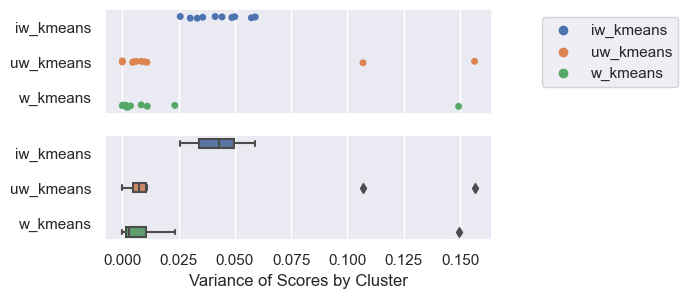

In [10]:
sns.set(rc={"figure.figsize":(5, 3)})
fig, axes = plt.subplots(2, 1, sharey=True)

sns.stripplot(x='var_score', y='weighting', data=cluster_df, jitter=True, hue='weighting', dodge=True, ax=axes[0])
axes[0].legend(loc='upper right', bbox_to_anchor=(1.5, 1))
axes[0].set(ylabel=None)
axes[0].set(xticklabels=[])
axes[0].set(xlabel=None)

sns.boxplot(x='var_score', y ='weighting', data=cluster_df, hue='weighting', dodge=True, ax=axes[1])
axes[1].set(ylabel=None)
axes[1].set(xlabel='Variance of Scores by Cluster')
axes[1].legend([], [], frameon=False)

plt.show()

In [11]:
def plot_cluster_scores(df):
  
    cluster_columns = ['uw_kmeans', 'w_kmeans', 'iw_kmeans']
    
    # Set up the matplotlib figure
    num_clusters = len(cluster_columns)
    fig, axs = plt.subplots(num_clusters, 1, figsize=(8, 4*num_clusters))
    
    for i, cluster_column in enumerate(cluster_columns):
        ax = axs[i]
        sns.countplot(data=df, x=cluster_column, hue='pattern_flag', ax=ax)
        ax.set_title(f'Score Counts by {cluster_column}')
        ax.set_xlabel('Cluster')
        ax.set_ylabel('Count')
    
    plt.tight_layout()
    plt.show()

c:\Users\vilce\AppData\Local\miniconda3\envs\llm_env\Lib\site-packages\IPython\core\pylabtools.py:152: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "orientation" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\vilce\AppData\Local\miniconda3\envs\llm_env\Lib\site-packages\IPython\core\pylabtools.py:152: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "facecolor" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\vilce\AppData\Local\miniconda3\envs\llm_env\Lib\site-packages\IPython\core\pylabtools.py:152: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "edgecolor" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\vilce\AppData\Local\miniconda3\envs

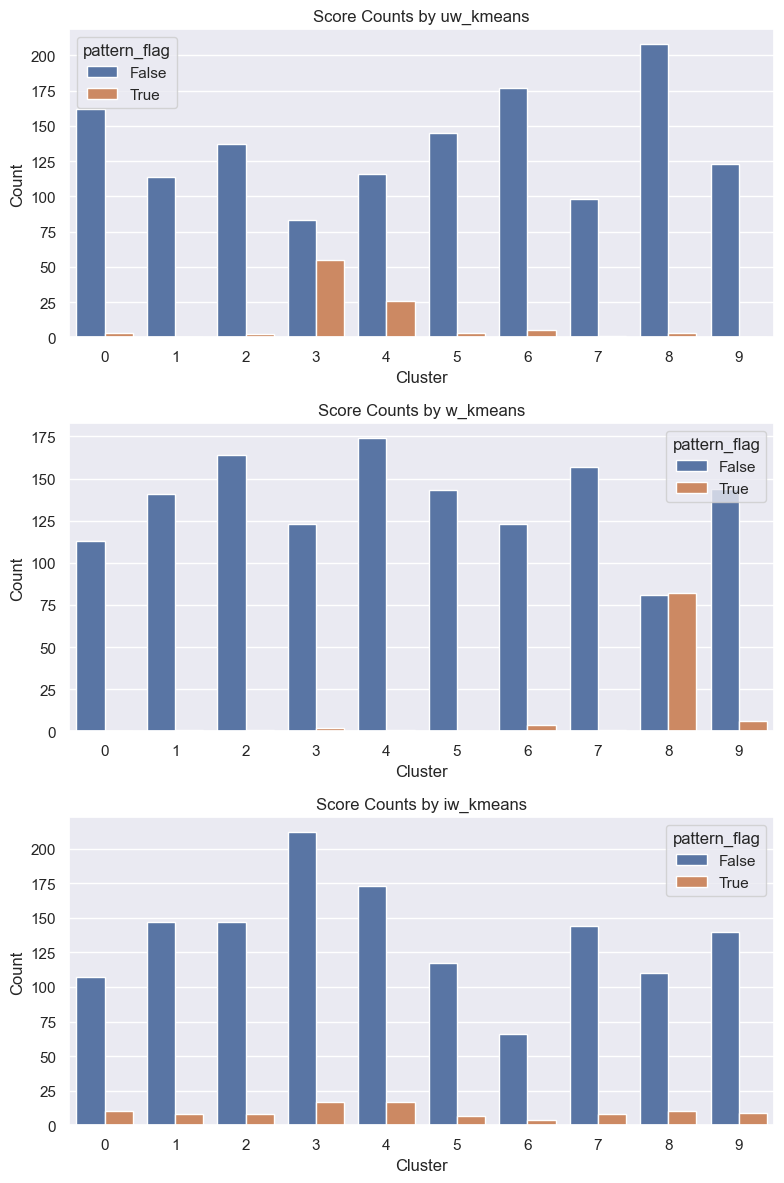

In [12]:
plot_cluster_scores(dolly_cqa_df)

Here is another way I think could potentially give us better results in emphasizing or de-emphasizing an aspect of interest:

1. Identify good sentences representative of the aspect of interest (e.g. a specific subject, or a particular type of question): We have this already.

2. Instead of training a linear classifier or regressor, we create an embedding vector representative of that aspect: We could simply take the mean of all embedded sentences we identify in 1. We also create an embedding vector non-representative of that aspect in the same way using the sentences not flagged in 1.

3. Re-weight the sentences embeddings: Here we need a way to modify the original sentence embeddings by adding or subtracting the influence of the desired aspect. We can do that in this way:

    3.1. Project each sentence embedding vector onto the aspect embedding vectors computed earlier, creating "positive" and "negative" projections.

    3.2 Add each projection vector to the corresponding sentence embedding (if we want to increase the aspect influence in the embeddings) or subtract each projection vector from the corresponding sentence embedding (if we want to decrease the aspect influence in the embeddings).

    3.3 When creating weighted embedding vector, we do this in a way that we try to increase the influence of the "positive" projections and decrease the influence of "negative" projections into the sentences that we consider having the aspect of interest, and we also do the opposite for the sentences not having the aspect of interest.
    
    3.4 When creating inverse-weighted embedding vectors, we do the opposite we did for the weighted vectors. 

In [13]:
dolly_cqa_df['score'] = dolly_cqa_df['pattern_flag']

pos_aspect_embedding = np.mean(dolly_cqa_df[dolly_cqa_df['pattern_flag'] == True]['embeddings_mini_lm'])
pos_aspect_embedding = pos_aspect_embedding / np.linalg.norm(pos_aspect_embedding)

neg_aspect_embedding = np.mean(dolly_cqa_df[dolly_cqa_df['pattern_flag'] == False]['embeddings_mini_lm'])
neg_aspect_embedding = neg_aspect_embedding / np.linalg.norm(neg_aspect_embedding)

dolly_cqa_df['w_embeddings'] = dolly_cqa_df['embeddings_mini_lm']
dolly_cqa_df['iw_embeddings'] = dolly_cqa_df['embeddings_mini_lm']

alpha = 1.25

for i, embedding in enumerate(dolly_cqa_df['embeddings_mini_lm']):
    embedding = embedding / np.linalg.norm(embedding)
    pos_projection = np.dot(embedding, pos_aspect_embedding.T) * pos_aspect_embedding
    pos_projection = pos_projection.reshape(-1,)
    neg_projection = np.dot(embedding, neg_aspect_embedding.T) * neg_aspect_embedding
    neg_projection = neg_projection.reshape(-1,)
    if dolly_cqa_df['pattern_flag'].iloc[i] == True:
        dolly_cqa_df['w_embeddings'].iloc[i] = embedding + alpha * (pos_projection - neg_projection)
        dolly_cqa_df['iw_embeddings'].iloc[i] = embedding - alpha * (pos_projection - neg_projection)
    else:
        dolly_cqa_df['w_embeddings'].iloc[i] = embedding + alpha * (neg_projection - pos_projection)
        dolly_cqa_df['iw_embeddings'].iloc[i] = embedding - alpha * (neg_projection - pos_projection)

n_clusters = 10
seed=0
uw_kmeans = KMeans(n_clusters=n_clusters, random_state=seed, n_init="auto").fit( [v for v in dolly_cqa_df['embeddings_mini_lm']])
w_kmeans = KMeans(n_clusters=n_clusters, random_state=seed, n_init="auto").fit( [v for v in dolly_cqa_df['w_embeddings']])
iw_kmeans = KMeans(n_clusters=n_clusters, random_state=seed, n_init="auto").fit( [v for v in dolly_cqa_df['iw_embeddings']])

dolly_cqa_df['uw_kmeans'] = uw_kmeans.labels_
dolly_cqa_df['w_kmeans'] = w_kmeans.labels_
dolly_cqa_df['iw_kmeans'] = iw_kmeans.labels_

cluster_df = dolly_cqa_df[['uw_kmeans', 'w_kmeans', 'iw_kmeans', 'score']]
cluster_df = pd.melt(cluster_df, id_vars=['score'], var_name='weighting', value_name='cluster_id')
cluster_df = cluster_df.groupby(["weighting", "cluster_id"]).agg({'score': ['mean', 'var']}).reset_index()
cluster_df.columns = ['weighting', 'cluster_id', 'mean_score', 'var_score']

C:\Users\vilce\AppData\Local\Temp\ipykernel_12732\3384377563.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dolly_cqa_df['w_embeddings'].iloc[i] = embedding + alpha * (neg_projection - pos_projection)
C:\Users\vilce\AppData\Local\Temp\ipykernel_12732\3384377563.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dolly_cqa_df['iw_embeddings'].iloc[i] = embedding - alpha * (neg_projection - pos_projection)
C:\Users\vilce\AppData\Local\Temp\ipykernel_12732\3384377563.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://panda

c:\Users\vilce\AppData\Local\miniconda3\envs\llm_env\Lib\site-packages\IPython\core\pylabtools.py:152: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "orientation" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\vilce\AppData\Local\miniconda3\envs\llm_env\Lib\site-packages\IPython\core\pylabtools.py:152: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "facecolor" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\vilce\AppData\Local\miniconda3\envs\llm_env\Lib\site-packages\IPython\core\pylabtools.py:152: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "edgecolor" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\vilce\AppData\Local\miniconda3\envs

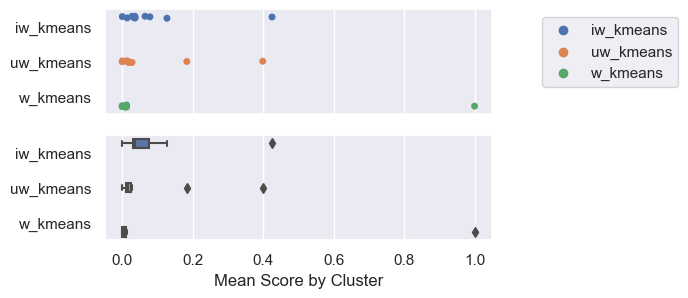

In [14]:
sns.set(rc={"figure.figsize":(5, 3)})
fig, axes = plt.subplots(2, 1, sharey=True)

sns.stripplot(x='mean_score', y='weighting', data=cluster_df, jitter=True, hue='weighting', dodge=True, ax=axes[0])
axes[0].legend(loc='upper right', bbox_to_anchor=(1.5, 1))
axes[0].set(ylabel=None)
axes[0].set(xticklabels=[])
axes[0].set(xlabel=None)

sns.boxplot(x='mean_score', y ='weighting', data=cluster_df, hue='weighting', dodge=True, ax=axes[1])
axes[1].set(ylabel=None)
axes[1].set(xlabel='Mean Score by Cluster')
axes[1].legend([], [], frameon=False)

plt.show()

c:\Users\vilce\AppData\Local\miniconda3\envs\llm_env\Lib\site-packages\IPython\core\pylabtools.py:152: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "orientation" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\vilce\AppData\Local\miniconda3\envs\llm_env\Lib\site-packages\IPython\core\pylabtools.py:152: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "facecolor" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\vilce\AppData\Local\miniconda3\envs\llm_env\Lib\site-packages\IPython\core\pylabtools.py:152: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "edgecolor" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\vilce\AppData\Local\miniconda3\envs

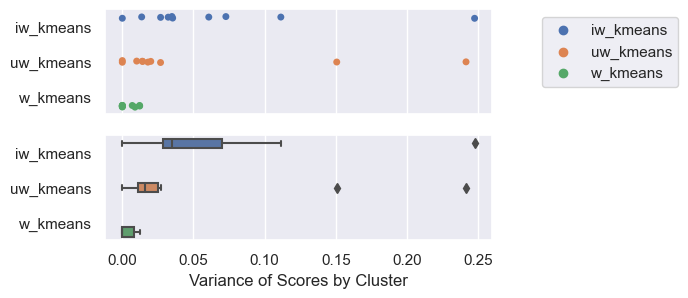

In [15]:
sns.set(rc={"figure.figsize":(5, 3)})
fig, axes = plt.subplots(2, 1, sharey=True)

sns.stripplot(x='var_score', y='weighting', data=cluster_df, jitter=True, hue='weighting', dodge=True, ax=axes[0])
axes[0].legend(loc='upper right', bbox_to_anchor=(1.5, 1))
axes[0].set(ylabel=None)
axes[0].set(xticklabels=[])
axes[0].set(xlabel=None)

sns.boxplot(x='var_score', y ='weighting', data=cluster_df, hue='weighting', dodge=True, ax=axes[1])
axes[1].set(ylabel=None)
axes[1].set(xlabel='Variance of Scores by Cluster')
axes[1].legend([], [], frameon=False)

plt.show()

c:\Users\vilce\AppData\Local\miniconda3\envs\llm_env\Lib\site-packages\IPython\core\pylabtools.py:152: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "orientation" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\vilce\AppData\Local\miniconda3\envs\llm_env\Lib\site-packages\IPython\core\pylabtools.py:152: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "facecolor" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\vilce\AppData\Local\miniconda3\envs\llm_env\Lib\site-packages\IPython\core\pylabtools.py:152: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "edgecolor" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\vilce\AppData\Local\miniconda3\envs

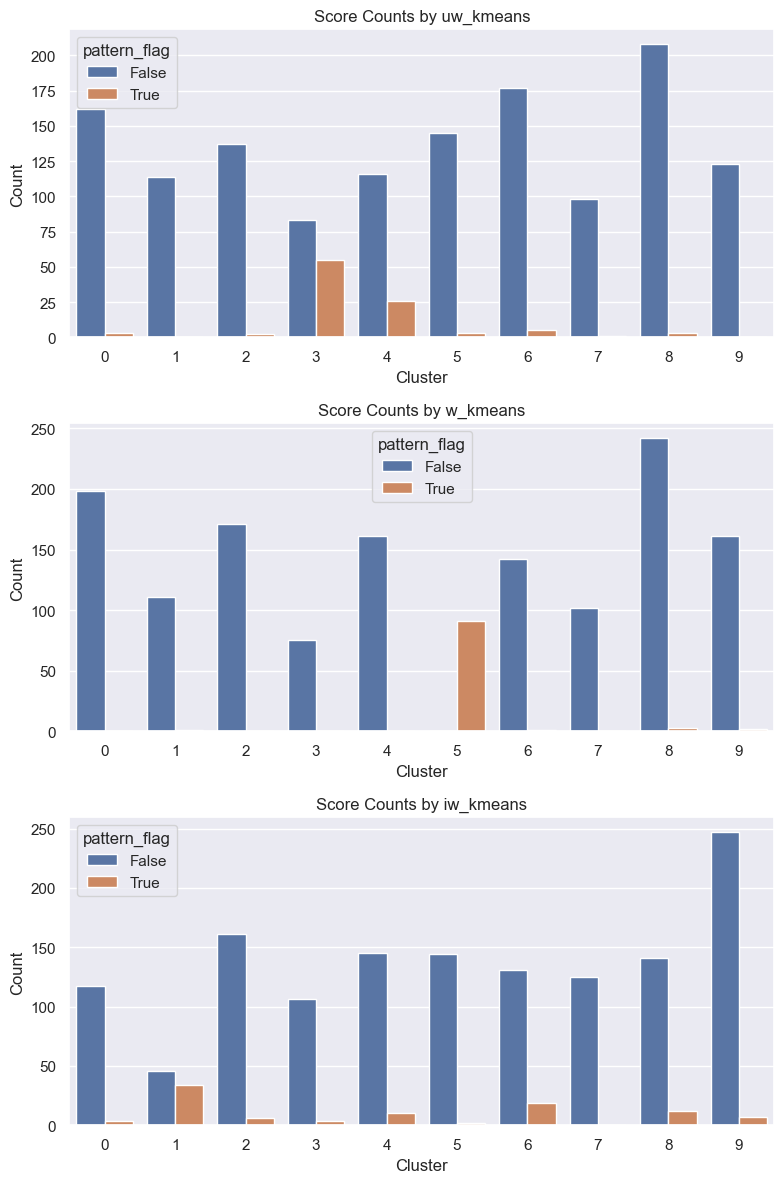

In [16]:
plot_cluster_scores(dolly_cqa_df)